In [9]:
# Data processing 
import numpy as np
import pandas as pd
import json

# Data vizualizations
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Data Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import enchant
import re
import unidecode

In [10]:
# Import json files with train and test samples 
with open("train.json") as f:
    data_set = json.load(f)
print(data_set[0])
print(data_set[0]['id'])
print(data_set[0]['cuisine'])
print(data_set[0]['ingredients'])
print(data_set[0]['ingredients'][0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}
10259
greek
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
romaine lettuce


In [11]:
print("First five elements in our train sample:")
train = pd.read_json('train.json')
train.head()

First five elements in our train sample:


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [13]:
def read_data(file_name):
    with open(file_name) as f:
        data = json.load(f)
    id_list = []
    cuisin_list = []
    ingredients_list = []
    for element in data:
        id_list.append(element['id'])
        cuisin_list.append(element['cuisine'].lower())
        temp = []
        for e in element['ingredients']:
            no_space_list = e.split(" ")
            for i in no_space_list:
                if i: temp.append(i.lower())
        ingredients_list.append(temp)
    return id_list,cuisin_list,ingredients_list
    
id_list,cuisin_list,ingredients_list = read_data("train.json")
# id_list = int
# cuisin_list =
# ingredients_list =
assert len(id_list) == len(cuisin_list)
assert len(id_list) == len(ingredients_list)
print(ingredients_list[0])
print(data_set[0]['ingredients'])

['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion', 'seasoning', 'garbanzo', 'beans', 'feta', 'cheese', 'crumbles']
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']


In [14]:
# consider clean none, empty or only whitespace
count = 0
for cuisin in cuisin_list:
    if cuisin.isspace() or not cuisin:
        count += 1
print(count)
count = 0
for ingredients in ingredients_list:
    for element in ingredients:
        if element.isspace() or not element:
            count += 1
print(count)

0
0


In [15]:
# checking missing data 
#reference https://www.kaggle.com/codename007/cooking-cooking-cooking
print("The size of train data set is : ", len(id_list))
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total missing', 'Percent missing'])
missing_train_data.head(20)

The size of train data set is :  39774


,Total missing,Percent missing
ingredients,0,0.0
cuisine,0,0.0
id,0,0.0


In [16]:
# https://stackoverflow.com/questions/3788870/how-to-check-if-a-word-is-an-english-word-with-python
d = enchant.Dict("en_US")
not_word_list = []
for ingredients in ingredients_list:
    for element in ingredients:
        if element in not_word_list: continue
        if not d.check(element):
             not_word_list.append(element)
print("How many words not in English dictionary?",len(not_word_list))
print(not_word_list)

How many words not in English dictionary? 1382
['mayonaise', 'passata', 'garam', 'masala', 'chorizo', 'poblano', 'extra-virgin', 'swiss', 'shaoxing', 'italian', 'chipotle', 'chile', 'parmesan', 'all-purpose', 'gruyere', 'tumeric', 'greek', 'broiler-fryer', 'asian', 'broccolini', 'hoisin', 'thai', 'roma', 'low-fat', 'mein', 'andouille', 'cajun', 'chinese', 'johnsonville', 'worcestershire', 'five-spice', 'black-eyed', 'oscar', 'mayer', 'giardiniera', 'turbinado', 'serrano', 'crawfish', 'mirin', 'napa', 'quickcooking', 'monterey', 'pickapeppa', 'matcha', 'fenugreek', 'urad', 'dal', 'part-skim', 'yukon', '1%', 'tamari', 'chillies', 'pappardelle', 'gochujang', 'taiwanese', 'bok', 'choy', 'purée', 'manchego', 'dijon', 'membrillo', 'panko', 'flaxseed', 'tahini', 'penne', 'harissa', 'kalamata', 'colouring', 'madeira', 'foie', 'gras', 'demi-glace', 'fuyu', 'amchur', 'asiago', 'mascarpone', 'caul', 'kahlúa', 'epazote', 'tomatillos', 'pepitas', 'basmati', 'english', 'muffins,', 'rigate', 'ras', '

In [17]:
# can ignore
print("gyoza" in not_word_list)
print("kimchi" in not_word_list)
# can delete, consider as meaningless
print("el" in not_word_list)
# can fix (special character)
print("muffins," in not_word_list)
print("fat-free" in not_word_list)
print("hellmann''s" in not_word_list)
print("bertolli®" in not_word_list)
print("2%" in not_word_list)
print("oz.)" in not_word_list)
# can fix (accents)
print("brisée" in not_word_list)
print("pâté" in not_word_list)
print("fraîche" in not_word_list)
# can not fix
print("noodl" in not_word_list)

True
True
True
True
True
True
True
True
True
True
True
True
True


In [18]:
# Classified not English words in ingredients
special_characters_1_list = []
special_characters_2_list = []
special_characters_3_list = []
special_characters_4_list = []
special_characters_5_list = []
special_characters_6_list = []
for element in not_word_list:
    if "," in element:
        special_characters_1_list.append(element)
    if "-" in element:
        special_characters_2_list.append(element)
    if "'" in element:
        special_characters_3_list.append(element)
    if "®" in element:
        special_characters_4_list.append(element)
    if "%" in element:
        special_characters_5_list.append(element)
    if "." in element:
        special_characters_6_list.append(element)
print("Contain ',' in not English word list:",len(special_characters_1_list))
print(special_characters_1_list)
print("Contain '-' in not English word list:",len(special_characters_2_list))
print(special_characters_2_list)
print("Contain ''' in not English word list:",len(special_characters_3_list))
print(special_characters_3_list)
print("Contain '®' in not English word list:",len(special_characters_4_list))
print(special_characters_4_list)
print("Contain '%' in not English word list:",len(special_characters_5_list))
print(special_characters_5_list)
print("Contain '.' in not English word list:",len(special_characters_6_list))
print(special_characters_6_list)

Contain ',' in not English word list: 35
['muffins,', 'pepper,', 'beans,', 'corn,', 'chestnuts,', 'bacon,', 'cheese,', 'shrimp,', 'peppers,', 'vegetables,', 'boneless,', 'spinach,', 'fettuccine,', 'clams,', 'links,', 'noodles,', 'capers,', 'linguine,', 'garlic,', 'leaves,', 'tomatoes,', 'spaghetti,', 'bread,', 'pasta,', 'chilies,', 'concentrate,', 'white,', 'wine,', 'mussels,', 'topping,', 'crabmeat,', 'chops,', 'chicken,', 'tortellini,', 'tuna,']
Contain '-' in not English word list: 105
['extra-virgin', 'all-purpose', 'broiler-fryer', 'low-fat', 'five-spice', 'black-eyed', 'part-skim', 'demi-glace', 'reduced-fat', 'long-grain', 'bone-in', 'short-grain', 'whole-milk', 'extra-lean', 'hard-boiled', 'semi-sweet', 'steel-cut', 'fat-free', 'crisp-cooked', 'shell-on', 'sun-dried', 'double-acting', 'oven-ready', 'gluten-free', 'non-fat', 'brine-cured', 'bow-tie', 'quick-cooking', 'old-fashioned', 'parmigiano-reggiano', 'jell-o', 'stone-ground', 'fat-trimmed', 'self-rising', 'soft-boiled', 'm

In [19]:
# https://stackoverflow.com/questions/23996118/replace-special-characters-in-a-string-python
my_str = "muffins,"
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)
my_str = "extra-virgin"
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)
my_str = "campbell's"
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)
my_str = "bertolli®"
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)
my_str = "2%"
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)
my_str = "oz."
my_new_string = re.sub('[^a-z]', '', my_str)
print(my_str, " -> ", my_new_string)

muffins,  ->  muffins
extra-virgin  ->  extravirgin
campbell's  ->  campbells
bertolli®  ->  bertolli
2%  ->  
oz.  ->  oz


In [20]:
#find some containing phonetic symbol
special_phonetic_1_list = []
for element in not_word_list:
    if 'é' in element:
        special_phonetic_1_list.append(element)
    elif 'â' in element: 
        special_phonetic_1_list.append(element)
    elif 'î' in element:
        special_phonetic_1_list.append(element)
    elif 'à' in element:
        special_phonetic_1_list.append(element)
    elif 'ê' in element:
        special_phonetic_1_list.append(element)
print("Words containing French phonetic symbol like 'à', 'é', 'ê', 'â', 'é' total of", len(special_phonetic_1_list))
print(special_phonetic_1_list)

Words containing French phonetic symbol like 'à', 'é', 'ê', 'â', 'é' total of 14
['purée', 'fraîche', 'épices', 'rosé', 'pâte', 'brisée', 'neufchâtel', 'bâtarde', 'pâté', 'bénédictine', 'glacés', 'hellmannâ€™', 'filé', 'manié']


In [21]:
# https://stackoverflow.com/questions/44431730/how-to-replace-accented-characters-in-python/44432222
# python3 strings are unicode by default.
#convert utf-8 to normal text
my_str = "àéêöhello"
print(my_str," -> ",unidecode.unidecode("àéêöhello"))
my_str = "pâté"
print(my_str," -> ",unidecode.unidecode("pâté"))

àéêöhello  ->  aeeohello
pâté  ->  pate


In [22]:
deleted_list = []
for element in not_word_list:
    if "," and "-" in element:
        ingredients = re.sub('[^a-z]', '',element)
        deleted_list.append(ingredients)
    if "'" in element:
        ingredients = re.sub('[^a-z]', '',element)
        deleted_list.append(ingredients)
    if "®" in element:
        ingredients = re.sub('[^a-z]', '',element)
        deleted_list.append(ingredients)
    if "%" in element:
        ingredients = re.sub('[^a-z]', '',element)
        deleted_list.append(ingredients)
    if "." in element:
        ingredients = re.sub('[^a-z]', '',element)
        deleted_list.append(ingredients) 
print(len(deleted_list))


178


In [23]:
def clean_fix_ingredients(ingredients_list):
    result = []
    deleted_list = []
    for ingredients in ingredients_list:
        temp = []
        for element in ingredients:
            new_str = re.sub('[^a-z]', '', unidecode.unidecode(element))
            if (not new_str) or (len(new_str) <= 2): 
                if element not in deleted_list: deleted_list.append(element)
            else:
                temp.append(new_str) 
        result.append(temp)
        if not temp: print("Warning! A ingredients_list becomes empty!")
    return result, deleted_list
clean_ingredients_list, deleted_list = clean_fix_ingredients(ingredients_list)
assert(len(clean_ingredients_list) == len(ingredients_list))
print("A total of some meaningless word:", len(deleted_list))
print(deleted_list)

A total of some meaningless word: 61
['lo', '1%', 'el', '2%', 'in', 'of', 'de', '(', 'oz.)', '&', '(10', '4', 'or', 'i', 'no', 'st', 'ti', 'ox', 'mo', 'on', "'n", '100', 'ic', 'a', '95%', 'yu', '(14.5', "it'", 'du', '7', 'up', '40%', '-', 'au', 'o', 'mi', 'la', '8', '25%', 'di', '96%', '33%', 'dr.', '(15', 'd', '5', '(14', '00', '1', 'dr', 'v', 'v8', '43', ',', '2', '1/2', 'to', '3', 'lb.', 'do', 's']


In [120]:
def compress_ingredients(ingredients_list):
    result = []
    for ingredients in ingredients_list:
        result.append(" ".join(ingredients))
    return result
compress_clean_ingredients_list = compress_ingredients(clean_ingredients_list)
print(compress_clean_ingredients_list)
print(compress_clean_ingredients_list[100])

pper garlic couscous curry powder vegetable broth toasted sesame oil canola oil ground cinnamon chili powder broccoli ground turmeric ajwain sea salt edamame hing powder', 'toasted pecans loosely packed fresh basil leaves olive oil garlic cloves pepper salt parmesan cheese lemon juice', 'olive oil feta cheese crumbles tomatoes salt olives purple onion cucumber pepper lemon juice dried oregano', 'ice cubes tequila strawberries white sugar basil leaves orange liqueur lemon juice', 'baguette capers oil pitted kalamata olives dried oregano olive oil', 'olive oil sundried tomatoes oil basil pesto sauce garlic boneless skinless chicken breast halves ricotta cheese noodles dried basil feta cheese crumbles', 'pepper roma tomatoes salt olive oil boneless skinless chicken breasts mango lime jalapeno chilies chopped cilantro garlic powder purple onion', 'reduced sodium chicken broth sesame oil shrimp green bell pepper fresh ginger salt chinkiang vinegar tomato paste minced garlic crushed red pepp

<AxesSubplot:>

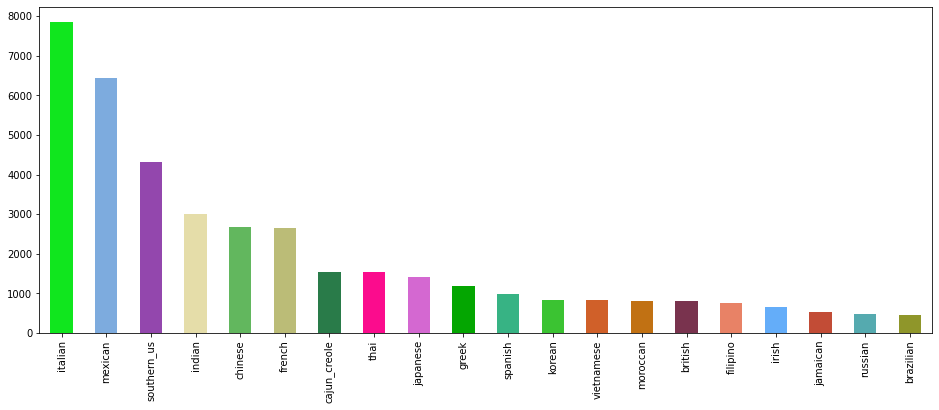

In [24]:
def random_colours(number_of_colors): #reference: https://www.kaggle.com/tanulsingh077/what-s-cooking
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors
train['cuisine'].value_counts().plot.bar(color=random_colours(20),figsize=(16,6))

In [10]:
#The first 10 most common ingredients in the train data
#reference https://www.kaggle.com/tanulsingh077/what-s-cooking
top = Counter([item for element in train['ingredients'] for item in element])
most_ingredients = pd.DataFrame(top.most_common(10),columns= ['ingrdients','count'])
most_ingredients.head(10)

,ingrdients,count
0,salt,18049
1,onions,7972
2,olive oil,7972
3,water,7457
4,garlic,7380
5,sugar,6434
6,garlic cloves,6237
7,butter,4848
8,ground black pepper,4785
9,all-purpose flour,4632


<AxesSubplot:xlabel='total_count', ylabel='ingredients'>

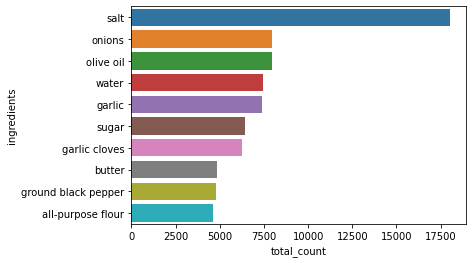

In [16]:
most_ingredients = pd.DataFrame(top.most_common(10))
most_ingredients.columns = ['ingredients','total_count']
sns.barplot(x='total_count',y='ingredients',data=most_ingredients)

In [160]:
cuisine_num_dic = {}
for cuisine in cuisin_list:
    if cuisine not in cuisine_num_dic:
        cuisine_num_dic[cuisine] = 0
    cuisine_num_dic[cuisine] = cuisine_num_dic[cuisine] + 1
#plt.bar(range(len(cuisin_num_dic)), list(cuisin_num_dic.values()), align='center')
# plt.xticks(range(len(cuisin_num_dic)), list(cuisin_num_dic.keys()))
#plt.show()
print(cuisine_num_dic)

{'greek': 1175, 'southern_us': 4320, 'filipino': 755, 'indian': 3003, 'jamaican': 526, 'spanish': 989, 'italian': 7838, 'mexican': 6438, 'chinese': 2673, 'british': 804, 'thai': 1539, 'vietnamese': 825, 'cajun_creole': 1546, 'brazilian': 467, 'french': 2646, 'japanese': 1423, 'irish': 667, 'korean': 830, 'moroccan': 821, 'russian': 489}


,count


In [37]:
# https://stackoverflow.com/questions/46010617/do-i-use-the-same-tfidf-vocabulary-in-k-fold-cross-validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
clf = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))
scores = cross_validate(clf, compress_clean_ingredients_list, cuisin_list, scoring=['accuracy'], cv=5, return_train_score=False)
print(scores) 

{'fit_time': array([68.08375406, 66.49377298, 64.03545499, 67.65687108, 66.67331791]), 'score_time': array([24.06588101, 22.65940809, 24.32393074, 22.54643989, 23.86740923]), 'test_accuracy': array([0.7857951 , 0.79044626, 0.7857951 , 0.78202388, 0.79117425])}
